In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from collections import OrderedDict

import xgboost
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse, accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score

In [2]:
config = OrderedDict([
    ('10/09/2012', [
        'AC', 'AEV', 'AGI', 'ALI', 'AP', 'BDO', 'PCOR', 'BPI', 'DMC', 'FGEN',
        'GLO', 'MER', 'ICT', 'JFC', 'JGS', 'BEL', 'MBT', 'MEG', 'MWC', 'MPI',
        'PX', 'RLC', 'EDC', 'SCC', 'SMDC', 'SM', 'SMC', 'SMPH', 'TEL', 'URC', 'PSEI'
    ]),
    ('11/03/2013', [
        'AC', 'AEV', 'AGI', 'ALI', 'AP', 'BDO', 'PCOR', 'BPI', 'DMC', 'FGEN',
        'GLO', 'MER', 'ICT', 'JFC', 'JGS', 'BEL', 'MBT', 'MEG', 'MWC', 'MPI',
        'PX', 'RLC', 'EDC', 'SCC', 'BLOOM', 'SM', 'SMC', 'SMPH', 'TEL', 'URC', 'PSEI'
    ]),
    ('09/16/2013', [
        'AC', 'AEV', 'AGI', 'ALI', 'AP', 'BDO', 'PCOR', 'BPI', 'DMC', 'FGEN',
        'GLO', 'GTCAP', 'ICT', 'JFC', 'JGS', 'LTG', 'MBT', 'MEG', 'MWC', 'MPI',
        'PX', 'RLC', 'EDC', 'SCC', 'BLOOM', 'SM', 'SMC', 'SMPH', 'TEL', 'URC', 'PSEI'
    ]),
    ('03/17/2014', [
        'AC', 'AEV', 'AGI', 'ALI', 'AP', 'BDO', 'PCOR', 'BPI', 'DMC', 'FGEN',
        'GLO', 'GTCAP', 'ICT', 'JFC', 'JGS', 'LTG', 'MBT', 'MEG', 'MER', 'MPI',
        'PX', 'RLC', 'EDC', 'SCC', 'BLOOM', 'SM', 'SMC', 'SMPH', 'TEL', 'URC', 'PSEI'
    ]),
    ('09/15/2014', [
        'AC', 'AEV', 'AGI', 'ALI', 'AP', 'BDO', 'PCOR', 'BPI', 'DMC', 'FGEN',
        'GLO', 'GTCAP', 'ICT', 'JFC', 'JGS', 'LTG', 'MBT', 'MEG', 'MER', 'MPI',
        'EMP', 'RLC', 'EDC', 'SCC', 'BLOOM', 'SM', 'SMC', 'SMPH', 'TEL', 'URC', 'PSEI'
    ]),
    ('12/09/2015', [
        'AC', 'AEV', 'AGI', 'ALI', 'AP', 'BDO', 'PCOR', 'BPI', 'DMC', 'FGEN',
        'GLO', 'GTCAP', 'ICT', 'JFC', 'JGS', 'LTG', 'MBT', 'MEG', 'MER', 'MPI',
        'EMP', 'RLC', 'EDC', 'SCC', 'SECB', 'SM', 'SMC', 'SMPH', 'TEL', 'URC', 'PSEI'
    ]),
    ('03/13/2017', [
        'AC', 'AEV', 'AGI', 'ALI', 'AP', 'BDO', 'PCOR', 'BPI', 'DMC', 'FGEN',
        'GLO', 'GTCAP', 'ICT', 'JFC', 'JGS', 'LTG', 'MBT', 'MEG', 'MER', 'MPI',
        'PGOLD', 'RLC', 'EDC', 'SCC', 'SECB', 'SM', 'SMC', 'SMPH', 'TEL', 'URC', 'PSEI'
    ]),
    ('09/28/2017', [
        'AC', 'AEV', 'AGI', 'ALI', 'AP', 'BDO', 'PCOR', 'BPI', 'DMC', 'FGEN',
        'GLO', 'GTCAP', 'ICT', 'JFC', 'JGS', 'LTG', 'MBT', 'MEG', 'MER', 'MPI',
        'PGOLD', 'RLC', 'RRHI', 'SCC', 'SECB', 'SM', 'SMC', 'SMPH', 'TEL', 'URC', 'PSEI'
    ]),
    ('02/18/2019', [
        'AC', 'AEV', 'AGI', 'ALI', 'AP', 'BDO', 'BLOOM', 'BPI', 'DMC', 'FGEN',
        'GLO', 'GTCAP', 'ICT', 'JFC', 'JGS', 'LTG', 'MBT', 'MEG', 'MER', 'MPI',
        'PGOLD', 'RLC', 'RRHI', 'SCC', 'SECB', 'SM', 'SMC', 'SMPH', 'TEL', 'URC', 'PSEI'
    ]),
])

In [3]:
main_df = pd.read_csv('consolidated_psei_quotes.csv', usecols=lambda x: 'Unnamed' not in x)[2:-11]
tweets_df = pd.read_csv('combined_tweets_with_sentiment_scores.csv', index_col=0)

c:\users\lex\docume~1\ftwsch~1\env\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# because the dates aren't zero padded :/
main_df['date'] = main_df['date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y').strftime('%m/%d/%Y'))
main_df

,symbol,date,open,high,low,close,volume,nfbs,previous_close
2,^PSEi,10/10/2012,5394.09,5408.02,5365.17,5369.60,6908518,-518407,5394.90
3,^PSEi,10/11/2012,5376.19,5384.83,5353.47,5353.47,5582156,-314692,5369.60
4,^PSEi,10/12/2012,5353.71,5372.68,5353.71,5369.72,27489636,-12742649,5353.47
5,^PSEi,10/15/2012,5366.92,5383.22,5360.91,5383.22,9100097,-515539,5369.72
6,^PSEi,10/16/2012,5383.90,5406.02,5383.90,5399.94,7155385,-410688,5383.22
...,...,...,...,...,...,...,...,...,...
1738,^PSEi,12/19/2019,7751.21,7751.21,7617.75,7653.94,12599420,-2048227,7733.67
1739,^PSEi,12/20/2019,7643.99,7773.12,7469.41,7773.12,13153106,-1271056,7653.94
1740,^PSEi,12/23/2019,7745.96,7872.60,7745.26,7872.60,8296349,-1219944,7773.12
1741,^PSEi,12/26/2019,7794.53,7842.28,7772.97,7842.28,3602654,143382,7872.60


In [5]:
main_df['log_return'] = np.log(main_df['close'] / main_df['previous_close'])
main_df

,symbol,date,open,high,low,close,volume,nfbs,previous_close,log_return
2,^PSEi,10/10/2012,5394.09,5408.02,5365.17,5369.60,6908518,-518407,5394.90,-0.004701
3,^PSEi,10/11/2012,5376.19,5384.83,5353.47,5353.47,5582156,-314692,5369.60,-0.003008
4,^PSEi,10/12/2012,5353.71,5372.68,5353.71,5369.72,27489636,-12742649,5353.47,0.003031
5,^PSEi,10/15/2012,5366.92,5383.22,5360.91,5383.22,9100097,-515539,5369.72,0.002511
6,^PSEi,10/16/2012,5383.90,5406.02,5383.90,5399.94,7155385,-410688,5383.22,0.003101
...,...,...,...,...,...,...,...,...,...,...
1738,^PSEi,12/19/2019,7751.21,7751.21,7617.75,7653.94,12599420,-2048227,7733.67,-0.010363
1739,^PSEi,12/20/2019,7643.99,7773.12,7469.41,7773.12,13153106,-1271056,7653.94,0.015451
1740,^PSEi,12/23/2019,7745.96,7872.60,7745.26,7872.60,8296349,-1219944,7773.12,0.012717
1741,^PSEi,12/26/2019,7794.53,7842.28,7772.97,7842.28,3602654,143382,7872.60,-0.003859


In [6]:
# because 1500 turns to 1.5K :/
tweets_df['favorite_count'] = tweets_df['favorite_count'].apply(
    lambda x: float(x) if 'K' not in str(x) else float(str(x).strip('K')) * 1000)
tweets_df.head()

,symbol,epoch_time,name,handle,url,tweet,reply_count,retweet_count,favorite_count,date,sentiment_score,label
0,AC,1192399907,D,davvyk,https://twitter.com/davvyk/status/335801692,hope england flatten the $ac)sts in RWC,0,0,0.0,10/15/2007,"{'neg': 0.0, 'neu': 0.674, 'pos': 0.326, 'comp...",1
1,AC,1218207877,JKIngram84,JKIngram154,https://twitter.com/JKIngram154/status/881583626,I´ve been fighting with banks for the last 12 ...,0,0,0.0,08/09/2008,"{'neg': 0.095, 'neu': 0.53, 'pos': 0.375, 'com...",1
2,AC,1261780693,"DIRECTED BY\r\nAC,🎥",mikemikefilms,https://twitter.com/mikemikefilms/status/70438...,& we STILL gotta hit up $ac!.. Hmm I wonder if...,0,0,0.0,12/26/2009,"{'neg': 0.136, 'neu': 0.767, 'pos': 0.098, 'co...",-1
3,AC,1261298199,BABY D,DEONNAROCKSTARR,https://twitter.com/DEONNAROCKSTARR/status/685...,OK GUY$ IM READY 2 LI$TEN 2 LITTLE BIT MORE MU...,0,0,0.0,12/20/2009,"{'neg': 0.0, 'neu': 0.683, 'pos': 0.317, 'comp...",1
4,AC,1261154012,CAC40,CAC40feed,https://twitter.com/CAC40feed/status/6800979366,"$$ #Accor Stock update: Accor, Host, Hyatt, La...",0,0,0.0,12/19/2009,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1


In [7]:
def get_previous_day(date):
    return datetime.strptime(date, '%m/%d/%Y') - timedelta(days=1)

def format_date(date, format='%m/%d/%Y'):
    return date.strftime(format)

def get_member_stocks(date):
    parsed_date = get_previous_day(date)
    for change_date, member_stocks in config.items():
        parsed_change_date = datetime.strptime(change_date, '%m/%d/%Y')
        if parsed_date >= parsed_change_date:
            return member_stocks

def get_relevant_tweets(date):
    return tweets_df[(tweets_df['date'] == format_date(get_previous_day(date))) & (tweets_df['symbol'].isin(get_member_stocks(date)))]

In [8]:
main_df['tweet_count'] = main_df['date'].apply(lambda date: len(get_relevant_tweets(date).index))

In [9]:
main_df.head()

,symbol,date,open,high,low,close,volume,nfbs,previous_close,log_return,tweet_count
2,^PSEi,10/10/2012,5394.09,5408.02,5365.17,5369.60,6908518,-518407,5394.90,-0.004701,16
3,^PSEi,10/11/2012,5376.19,5384.83,5353.47,5353.47,5582156,-314692,5369.60,-0.003008,11
4,^PSEi,10/12/2012,5353.71,5372.68,5353.71,5369.72,27489636,-12742649,5353.47,0.003031,24
5,^PSEi,10/15/2012,5366.92,5383.22,5360.91,5383.22,9100097,-515539,5369.72,0.002511,23
6,^PSEi,10/16/2012,5383.90,5406.02,5383.90,5399.94,7155385,-410688,5383.22,0.003101,14


In [10]:
# main_df['favorite_boost_score'] = main_df['date'].apply(lambda x: tweets_df[tweets_df['date'] == x])
# date = main_df.iloc[0].date
# tweet_subset = tweets_df[tweets_df['date'] == date]
# print(len(tweet_subset[tweet_subset['label'] == 1].index))
# print(tweet_subset['label']*(abs(tweet_subset['label']) + (0.5*tweet_subset['favorite_count'])))

In [11]:
main_df['positive_tweets_count'] = main_df['date'].apply(
    lambda date: len(tweets_df[(tweets_df['date'] == format_date(get_previous_day(date))) & (tweets_df['label'] == 1) & (tweets_df['symbol'].isin(get_member_stocks(date)))].index))
main_df

,symbol,date,open,high,low,close,volume,nfbs,previous_close,log_return,tweet_count,positive_tweets_count
2,^PSEi,10/10/2012,5394.09,5408.02,5365.17,5369.60,6908518,-518407,5394.90,-0.004701,16,14
3,^PSEi,10/11/2012,5376.19,5384.83,5353.47,5353.47,5582156,-314692,5369.60,-0.003008,11,11
4,^PSEi,10/12/2012,5353.71,5372.68,5353.71,5369.72,27489636,-12742649,5353.47,0.003031,24,23
5,^PSEi,10/15/2012,5366.92,5383.22,5360.91,5383.22,9100097,-515539,5369.72,0.002511,23,23
6,^PSEi,10/16/2012,5383.90,5406.02,5383.90,5399.94,7155385,-410688,5383.22,0.003101,14,14
...,...,...,...,...,...,...,...,...,...,...,...,...
1738,^PSEi,12/19/2019,7751.21,7751.21,7617.75,7653.94,12599420,-2048227,7733.67,-0.010363,274,244
1739,^PSEi,12/20/2019,7643.99,7773.12,7469.41,7773.12,13153106,-1271056,7653.94,0.015451,223,203
1740,^PSEi,12/23/2019,7745.96,7872.60,7745.26,7872.60,8296349,-1219944,7773.12,0.012717,82,80
1741,^PSEi,12/26/2019,7794.53,7842.28,7772.97,7842.28,3602654,143382,7872.60,-0.003859,56,53


In [12]:
main_df['positive_tweets_ratio'] =  (main_df['positive_tweets_count'] / main_df['tweet_count']).fillna(0)
main_df
# main_df[main_df.isnull().any(axis=1)]

,symbol,date,open,high,low,close,volume,nfbs,previous_close,log_return,tweet_count,positive_tweets_count,positive_tweets_ratio
2,^PSEi,10/10/2012,5394.09,5408.02,5365.17,5369.60,6908518,-518407,5394.90,-0.004701,16,14,0.875000
3,^PSEi,10/11/2012,5376.19,5384.83,5353.47,5353.47,5582156,-314692,5369.60,-0.003008,11,11,1.000000
4,^PSEi,10/12/2012,5353.71,5372.68,5353.71,5369.72,27489636,-12742649,5353.47,0.003031,24,23,0.958333
5,^PSEi,10/15/2012,5366.92,5383.22,5360.91,5383.22,9100097,-515539,5369.72,0.002511,23,23,1.000000
6,^PSEi,10/16/2012,5383.90,5406.02,5383.90,5399.94,7155385,-410688,5383.22,0.003101,14,14,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1738,^PSEi,12/19/2019,7751.21,7751.21,7617.75,7653.94,12599420,-2048227,7733.67,-0.010363,274,244,0.890511
1739,^PSEi,12/20/2019,7643.99,7773.12,7469.41,7773.12,13153106,-1271056,7653.94,0.015451,223,203,0.910314
1740,^PSEi,12/23/2019,7745.96,7872.60,7745.26,7872.60,8296349,-1219944,7773.12,0.012717,82,80,0.975610
1741,^PSEi,12/26/2019,7794.53,7842.28,7772.97,7842.28,3602654,143382,7872.60,-0.003859,56,53,0.946429


In [13]:
tweets_df['boosted_score'] = tweets_df.apply(
    lambda x: x['label'] * (abs(x['label']) + (0.5 * int(x['favorite_count']))), axis=1)
tweets_df

,symbol,epoch_time,name,handle,url,tweet,reply_count,retweet_count,favorite_count,date,sentiment_score,label,boosted_score
0,AC,1192399907,D,davvyk,https://twitter.com/davvyk/status/335801692,hope england flatten the $ac)sts in RWC,0,0,0.0,10/15/2007,"{'neg': 0.0, 'neu': 0.674, 'pos': 0.326, 'comp...",1,1.0
1,AC,1218207877,JKIngram84,JKIngram154,https://twitter.com/JKIngram154/status/881583626,I´ve been fighting with banks for the last 12 ...,0,0,0.0,08/09/2008,"{'neg': 0.095, 'neu': 0.53, 'pos': 0.375, 'com...",1,1.0
2,AC,1261780693,"DIRECTED BY\r\nAC,🎥",mikemikefilms,https://twitter.com/mikemikefilms/status/70438...,& we STILL gotta hit up $ac!.. Hmm I wonder if...,0,0,0.0,12/26/2009,"{'neg': 0.136, 'neu': 0.767, 'pos': 0.098, 'co...",-1,-1.0
3,AC,1261298199,BABY D,DEONNAROCKSTARR,https://twitter.com/DEONNAROCKSTARR/status/685...,OK GUY$ IM READY 2 LI$TEN 2 LITTLE BIT MORE MU...,0,0,0.0,12/20/2009,"{'neg': 0.0, 'neu': 0.683, 'pos': 0.317, 'comp...",1,1.0
4,AC,1261154012,CAC40,CAC40feed,https://twitter.com/CAC40feed/status/6800979366,"$$ #Accor Stock update: Accor, Host, Hyatt, La...",0,0,0.0,12/19/2009,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199471,URC,1505790466,MyTradePH-Abacus Sec,MyTradePH,https://twitter.com/MyTradePH/status/909977286...,"... $URC, $SMC, $BEL. Read the full report at ...",0,0,0.0,09/19/2017,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1,1.0
199472,URC,1505737174,kentir,ko_kom101,https://twitter.com/ko_kom101/status/909753762...,"coindera: Top 3\r\nURC,\r\nURC, $URC $BTC on Y...",0,0,1.0,09/18/2017,"{'neg': 0.0, 'neu': 0.917, 'pos': 0.083, 'comp...",1,1.5
199473,URC,1505736062,Shitcoin Calls,ShitcoinCalls,https://twitter.com/ShitcoinCalls/status/90974...,"New post in Shitcoin Calls: Top 3\r\nURC, $URC...",0,0,2.0,09/18/2017,"{'neg': 0.0, 'neu': 0.917, 'pos': 0.083, 'comp...",1,2.0
199474,URC,1505736031,Coindera,coindera,https://twitter.com/coindera/status/9097489714...,"Top 3\r\nURC,\r\nURC, $URC $BTC on @YobitExcha...",0,0,2.0,09/18/2017,"{'neg': 0.0, 'neu': 0.913, 'pos': 0.087, 'comp...",1,2.0


In [14]:
main_df['favorite_boosted_score'] = main_df['date'].apply(lambda date: sum((get_relevant_tweets(date))['boosted_score']))
main_df

,symbol,date,open,high,low,close,volume,nfbs,previous_close,log_return,tweet_count,positive_tweets_count,positive_tweets_ratio,favorite_boosted_score
2,^PSEi,10/10/2012,5394.09,5408.02,5365.17,5369.60,6908518,-518407,5394.90,-0.004701,16,14,0.875000,12.5
3,^PSEi,10/11/2012,5376.19,5384.83,5353.47,5353.47,5582156,-314692,5369.60,-0.003008,11,11,1.000000,12.0
4,^PSEi,10/12/2012,5353.71,5372.68,5353.71,5369.72,27489636,-12742649,5353.47,0.003031,24,23,0.958333,24.5
5,^PSEi,10/15/2012,5366.92,5383.22,5360.91,5383.22,9100097,-515539,5369.72,0.002511,23,23,1.000000,23.0
6,^PSEi,10/16/2012,5383.90,5406.02,5383.90,5399.94,7155385,-410688,5383.22,0.003101,14,14,1.000000,14.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1738,^PSEi,12/19/2019,7751.21,7751.21,7617.75,7653.94,12599420,-2048227,7733.67,-0.010363,274,244,0.890511,456.5
1739,^PSEi,12/20/2019,7643.99,7773.12,7469.41,7773.12,13153106,-1271056,7653.94,0.015451,223,203,0.910314,594.0
1740,^PSEi,12/23/2019,7745.96,7872.60,7745.26,7872.60,8296349,-1219944,7773.12,0.012717,82,80,0.975610,378.0
1741,^PSEi,12/26/2019,7794.53,7842.28,7772.97,7842.28,3602654,143382,7872.60,-0.003859,56,53,0.946429,74.0


In [15]:
main_df['hype_score'] = main_df['date'].apply(
    lambda date: sum(abs((get_relevant_tweets(date))['boosted_score'])))
main_df

,symbol,date,open,high,low,close,volume,nfbs,previous_close,log_return,tweet_count,positive_tweets_count,positive_tweets_ratio,favorite_boosted_score,hype_score
2,^PSEi,10/10/2012,5394.09,5408.02,5365.17,5369.60,6908518,-518407,5394.90,-0.004701,16,14,0.875000,12.5,16.5
3,^PSEi,10/11/2012,5376.19,5384.83,5353.47,5353.47,5582156,-314692,5369.60,-0.003008,11,11,1.000000,12.0,12.0
4,^PSEi,10/12/2012,5353.71,5372.68,5353.71,5369.72,27489636,-12742649,5353.47,0.003031,24,23,0.958333,24.5,26.5
5,^PSEi,10/15/2012,5366.92,5383.22,5360.91,5383.22,9100097,-515539,5369.72,0.002511,23,23,1.000000,23.0,23.0
6,^PSEi,10/16/2012,5383.90,5406.02,5383.90,5399.94,7155385,-410688,5383.22,0.003101,14,14,1.000000,14.5,14.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1738,^PSEi,12/19/2019,7751.21,7751.21,7617.75,7653.94,12599420,-2048227,7733.67,-0.010363,274,244,0.890511,456.5,567.5
1739,^PSEi,12/20/2019,7643.99,7773.12,7469.41,7773.12,13153106,-1271056,7653.94,0.015451,223,203,0.910314,594.0,728.0
1740,^PSEi,12/23/2019,7745.96,7872.60,7745.26,7872.60,8296349,-1219944,7773.12,0.012717,82,80,0.975610,378.0,429.0
1741,^PSEi,12/26/2019,7794.53,7842.28,7772.97,7842.28,3602654,143382,7872.60,-0.003859,56,53,0.946429,74.0,95.0


In [16]:
main_df['target'] = main_df.apply(lambda x: int(x['close'] > x['previous_close']), axis=1)
main_df

,symbol,date,open,high,low,close,volume,nfbs,previous_close,log_return,tweet_count,positive_tweets_count,positive_tweets_ratio,favorite_boosted_score,hype_score,target
2,^PSEi,10/10/2012,5394.09,5408.02,5365.17,5369.60,6908518,-518407,5394.90,-0.004701,16,14,0.875000,12.5,16.5,0
3,^PSEi,10/11/2012,5376.19,5384.83,5353.47,5353.47,5582156,-314692,5369.60,-0.003008,11,11,1.000000,12.0,12.0,0
4,^PSEi,10/12/2012,5353.71,5372.68,5353.71,5369.72,27489636,-12742649,5353.47,0.003031,24,23,0.958333,24.5,26.5,1
5,^PSEi,10/15/2012,5366.92,5383.22,5360.91,5383.22,9100097,-515539,5369.72,0.002511,23,23,1.000000,23.0,23.0,1
6,^PSEi,10/16/2012,5383.90,5406.02,5383.90,5399.94,7155385,-410688,5383.22,0.003101,14,14,1.000000,14.5,14.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1738,^PSEi,12/19/2019,7751.21,7751.21,7617.75,7653.94,12599420,-2048227,7733.67,-0.010363,274,244,0.890511,456.5,567.5,0
1739,^PSEi,12/20/2019,7643.99,7773.12,7469.41,7773.12,13153106,-1271056,7653.94,0.015451,223,203,0.910314,594.0,728.0,1
1740,^PSEi,12/23/2019,7745.96,7872.60,7745.26,7872.60,8296349,-1219944,7773.12,0.012717,82,80,0.975610,378.0,429.0,1
1741,^PSEi,12/26/2019,7794.53,7842.28,7772.97,7842.28,3602654,143382,7872.60,-0.003859,56,53,0.946429,74.0,95.0,0


In [17]:
main_df.to_csv('out.csv')

In [18]:
# from sklearn.preprocessing import StandardScaler
from tpot import TPOTClassifier

features = ['volume', 'nfbs', 'tweet_count', 'positive_tweets_ratio', 'favorite_boosted_score', 'hype_score']
X = main_df[features][:-249]
# X = StandardScaler().fit_transform(X)
y = main_df['target'][:-249]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=18)
# Initialize model
# model = LogisticRegression()
model = xgboost.XGBClassifier()
# model = TPOTClassifier(generations=10, verbosity=2)

# Fit model
model.fit(X_train, y_train)
# Predict prices for test data
y_predicted = model.predict(X_test)

print('Accuracy: {}'.format(accuracy_score(y_test, y_predicted)))
print('Precision: {}'.format(precision_score(y_test, y_predicted)))
print('Recall: {}'.format(recall_score(y_test, y_predicted)))
print('ROC AUC: {}'.format(roc_auc_score(y_test, y_predicted)))
print('Confusion Matrix:\n{}'.format(confusion_matrix(y_test, y_predicted)))

scores = cross_val_score(model, X, y, cv=5)
# print(scores)
print('CV score: {}'.format(np.average(scores)))

Accuracy: 0.6180904522613065
Precision: 0.6476190476190476
Recall: 0.6355140186915887
ROC AUC: 0.6166700528240553
Confusion Matrix:
[[165 111]
 [117 204]]
CV score: 0.6011829139637719


In [19]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [20]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X)

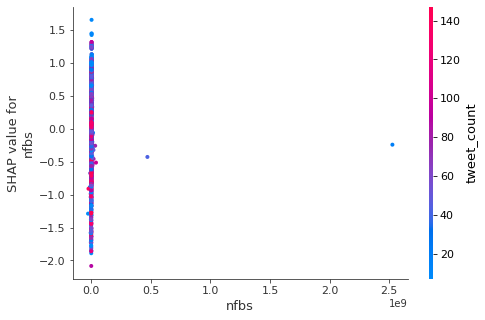

In [21]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("nfbs", shap_values, X)

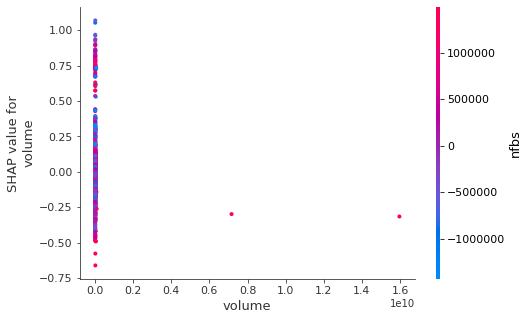

In [22]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("volume", shap_values, X)

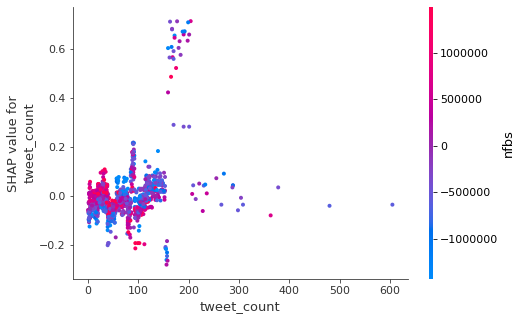

In [23]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("tweet_count", shap_values, X)

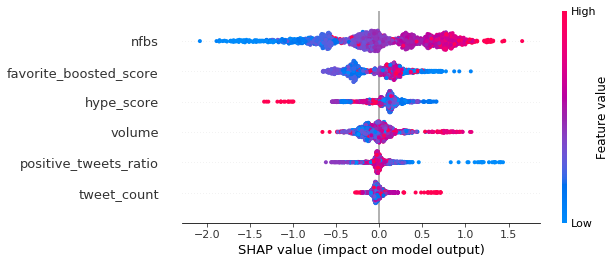

In [24]:
shap.summary_plot(shap_values, X)

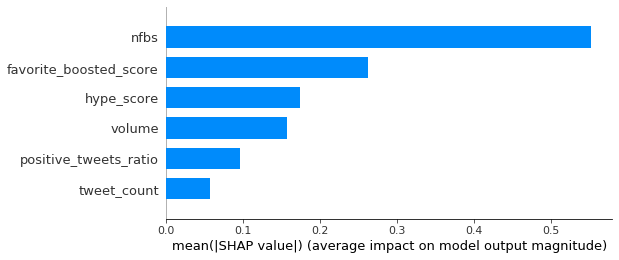

In [25]:
shap.summary_plot(shap_values, X, plot_type="bar")

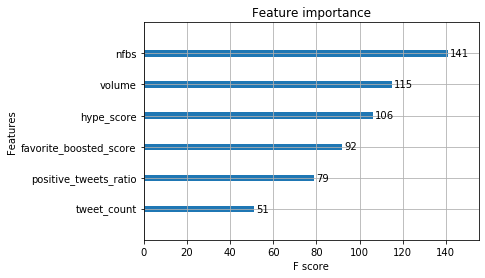

In [26]:
xgboost.plot_importance(model, importance_type='weight')

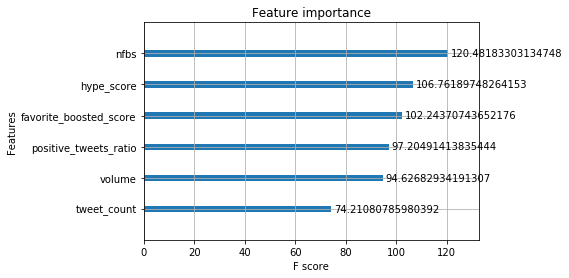

In [27]:
xgboost.plot_importance(model, importance_type='cover')

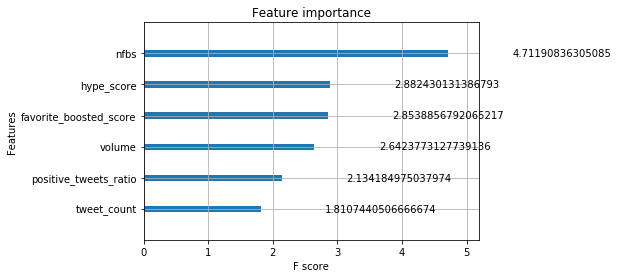

In [28]:
xgboost.plot_importance(model, importance_type='gain')

In [29]:
test_data = main_df.iloc[-249:]
test_data

,symbol,date,open,high,low,close,volume,nfbs,previous_close,log_return,tweet_count,positive_tweets_count,positive_tweets_ratio,favorite_boosted_score,hype_score,target
1494,^PSEi,12/12/2018,7455.98,7488.24,7425.66,7488.24,11904455,-984701,7451.08,0.004975,72,68,0.944444,75.5,88.5,1
1495,^PSEi,12/13/2018,7514.35,7556.24,7513.56,7522.92,6093320,324835,7488.24,0.004621,75,70,0.933333,116.0,126.0,1
1496,^PSEi,12/14/2018,7506.40,7559.27,7503.09,7524.37,6846972,-691234,7522.92,0.000193,68,65,0.955882,195.5,218.5,1
1497,^PSEi,12/17/2018,7501.27,7538.14,7490.56,7520.40,5935949,-822246,7524.37,-0.000528,44,41,0.931818,49.0,55.0,0
1498,^PSEi,12/18/2018,7478.36,7482.21,7397.23,7420.40,8497816,-652153,7520.40,-0.013386,108,102,0.944444,134.0,152.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1738,^PSEi,12/19/2019,7751.21,7751.21,7617.75,7653.94,12599420,-2048227,7733.67,-0.010363,274,244,0.890511,456.5,567.5,0
1739,^PSEi,12/20/2019,7643.99,7773.12,7469.41,7773.12,13153106,-1271056,7653.94,0.015451,223,203,0.910314,594.0,728.0,1
1740,^PSEi,12/23/2019,7745.96,7872.60,7745.26,7872.60,8296349,-1219944,7773.12,0.012717,82,80,0.975610,378.0,429.0,1
1741,^PSEi,12/26/2019,7794.53,7842.28,7772.97,7842.28,3602654,143382,7872.60,-0.003859,56,53,0.946429,74.0,95.0,0


In [30]:
X_test_data = test_data[features]
y_test_data = test_data['target']

y_test_data_predicted = model.predict(X_test_data)
print('Accuracy: {}'.format(accuracy_score(y_test_data, y_test_data_predicted)))
print('Precision: {}'.format(precision_score(y_test_data, y_test_data_predicted)))
print('Recall: {}'.format(recall_score(y_test_data, y_test_data_predicted)))
print('ROC AUC: {}'.format(roc_auc_score(y_test_data, y_test_data_predicted)))
print('Confusion Matrix:\n{}'.format(confusion_matrix(y_test_data, y_test_data_predicted)))

Accuracy: 0.6265060240963856
Precision: 0.625
Recall: 0.6692913385826772
ROC AUC: 0.6256292758487156
Confusion Matrix:
[[71 51]
 [42 85]]


In [31]:
y_test_data

1494    1
1495    1
1496    1
1497    0
1498    0
       ..
1738    0
1739    1
1740    1
1741    0
1742    0
Name: target, Length: 249, dtype: int64

In [32]:
y_test_data_predicted

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [33]:
test = X_test_data.copy()
test['target'] = y_test_data
test['predicted'] = y_test_data_predicted
test['date'] = test_data['date']
test.to_csv('predicted.csv')

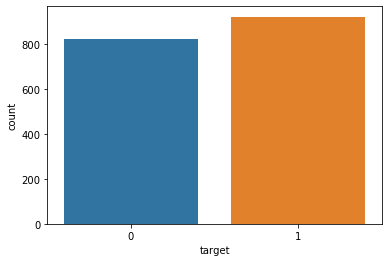

In [34]:
import seaborn as sns
main_df.describe()
sns.countplot(main_df['target'])
# sns.countplot(tweets_df['label'])

## Sentiment Analysis

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pattern.en import ngrams, sentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Data Preprocessing and Feature Engineering
import re
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

In [36]:
train_tweets = tweets_df[['tweet', 'label']]
test_tweets = tweets_df[['tweet']]

In [37]:
def text_processing(tweet):
    
    #Generating the list of words in the tweet (hastags and other punctuations removed)
    def form_sentence(tweet):
        tweet_blob = TextBlob(tweet)
        return ' '.join(tweet_blob.words)
    new_tweet = form_sentence(tweet)
#     print(tweet)
    
    #Removing stopwords and words with unusual symbols
    def no_user_alpha(tweet_list):
        tweet_list = [ele for ele in tweet_list.split() if ele != 'user']
        clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
        clean_s = ' '.join(clean_tokens)
        clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english')]
        return clean_mess
    no_punc_tweet = no_user_alpha(new_tweet)
#     print(no_punc_tweet)
    
    #Normalizing the words in tweets 
    def normalization(tweet_list):
        lem = WordNetLemmatizer()
        normalized_tweet = []
        for word in tweet_list:
            normalized_text = lem.lemmatize(word, 'v')
            normalized_tweet.append(normalized_text)
        return normalized_tweet
    
    
    return normalization(no_punc_tweet)

In [38]:
d = train_tweets.copy()
d = d.iloc[:10]
d['tweet_list'] = d['tweet'].apply(text_processing)
d.head()

,tweet,label,tweet_list
0,hope england flatten the $ac)sts in RWC,1,"[hope, england, flatten, ac, sts, RWC]"
1,I´ve been fighting with banks for the last 12 ...,1,"[fight, bank, last, hours, Fun, fun, fun, F, r..."
2,& we STILL gotta hit up $ac!.. Hmm I wonder if...,-1,"[STILL, get, ta, hit, ac, Hmm, wonder, aunt, l..."
3,OK GUY$ IM READY 2 LI$TEN 2 LITTLE BIT MORE MU...,1,"[OK, GUY, IM, READY, LI, TEN, LITTLE, BIT, MU,..."
4,"$$ #Accor Stock update: Accor, Host, Hyatt, La...",1,"[Accor, Stock, update, Accor, Host, Hyatt, LaS..."


In [39]:
# train_tweets['tweet_list'] = train_tweets['tweet'].apply(text_processing)
# test_tweets['tweet_list'] = test_tweets['tweet'].apply(text_processing)

X = train_tweets['tweet']
y = train_tweets['label']

In [40]:
# from sklearn.model_selection import train_test_split
# msg_train, msg_test, label_train, label_test = train_test_split(train_tweets['tweet'], train_tweets['label'], test_size=0.2)
# msg_test
# pipeline = Pipeline([
#     ('bow', CountVectorizer(analyzer=text_processing)),  # strings to token integer counts
#     ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
#     ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
# ])
# msg_train.fillna('', inplace=True)
# msg_test.fillna('', inplace=True)
# # msg_train.to_csv('test.csv')

# pipeline.fit(msg_train, label_train)

# predictions = pipeline.predict(msg_test)

# print(classification_report(predictions, label_test))
# print ('\n')
# print(confusion_matrix(predictions, label_test))
# print(accuracy_score(predictions, label_test))

## Exploration

In [41]:
main_df

,symbol,date,open,high,low,close,volume,nfbs,previous_close,log_return,tweet_count,positive_tweets_count,positive_tweets_ratio,favorite_boosted_score,hype_score,target
2,^PSEi,10/10/2012,5394.09,5408.02,5365.17,5369.60,6908518,-518407,5394.90,-0.004701,16,14,0.875000,12.5,16.5,0
3,^PSEi,10/11/2012,5376.19,5384.83,5353.47,5353.47,5582156,-314692,5369.60,-0.003008,11,11,1.000000,12.0,12.0,0
4,^PSEi,10/12/2012,5353.71,5372.68,5353.71,5369.72,27489636,-12742649,5353.47,0.003031,24,23,0.958333,24.5,26.5,1
5,^PSEi,10/15/2012,5366.92,5383.22,5360.91,5383.22,9100097,-515539,5369.72,0.002511,23,23,1.000000,23.0,23.0,1
6,^PSEi,10/16/2012,5383.90,5406.02,5383.90,5399.94,7155385,-410688,5383.22,0.003101,14,14,1.000000,14.5,14.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1738,^PSEi,12/19/2019,7751.21,7751.21,7617.75,7653.94,12599420,-2048227,7733.67,-0.010363,274,244,0.890511,456.5,567.5,0
1739,^PSEi,12/20/2019,7643.99,7773.12,7469.41,7773.12,13153106,-1271056,7653.94,0.015451,223,203,0.910314,594.0,728.0,1
1740,^PSEi,12/23/2019,7745.96,7872.60,7745.26,7872.60,8296349,-1219944,7773.12,0.012717,82,80,0.975610,378.0,429.0,1
1741,^PSEi,12/26/2019,7794.53,7842.28,7772.97,7842.28,3602654,143382,7872.60,-0.003859,56,53,0.946429,74.0,95.0,0


In [42]:
decrease = main_df[main_df['target'] == 0]
increase = main_df[main_df['target'] == 1]

In [43]:
print(decrease['nfbs'].mean())
print(increase['nfbs'].mean())

367650.26674786845
2938639.202173913


count    1.741000e+03
mean     1.726243e+06
std      6.165735e+07
min     -2.818710e+07
25%     -5.571770e+05
50%     -9.542200e+04
75%      3.519250e+05
max      2.528117e+09
Name: nfbs, dtype: float64

In [44]:
print(decrease['volume'].mean())
print(increase['volume'].mean())

16615402.556638246
25429138.175


In [45]:
print(decrease['tweet_count'].mean())
print(increase['tweet_count'].mean())

70.43239951278927
66.00108695652175


In [46]:
print(decrease['positive_tweets_ratio'].mean())
print(increase['positive_tweets_ratio'].mean())

0.9103791092546872
0.9134151727159631


In [47]:
print(decrease['hype_score'].mean())
print(increase['hype_score'].mean())

99.04019488428746
90.70271739130435


In [78]:
# idk how to make this work
# xgboost.plot_tree(model)

In [77]:
main_df.describe()

,open,high,low,close,volume,nfbs,previous_close,log_return,tweet_count,positive_tweets_count,positive_tweets_ratio,favorite_boosted_score,hype_score,target
count,1741.000000,1741.000000,1741.000000,1741.000000,1.741000e+03,1.741000e+03,1741.000000,1741.000000,1741.000000,1741.000000,1741.000000,1741.000000,1741.000000,1741.000000
mean,7301.617829,7338.694968,7258.323969,7300.715060,2.127286e+07,1.726243e+06,7299.324848,0.000213,68.090752,62.117748,0.911983,76.280586,94.634406,0.528432
std,711.262962,711.233268,707.512712,710.778461,4.191396e+08,6.165735e+07,712.137178,0.010373,48.714779,44.789719,0.073323,68.696608,86.216035,0.499334
min,5353.710000,5372.680000,5353.470000,5353.470000,6.339340e+05,-2.818710e+07,5353.470000,-0.069885,0.000000,0.000000,0.000000,-2.000000,0.000000,0.000000
25%,6842.620000,6872.320000,6799.220000,6838.420000,5.881257e+06,-5.571770e+05,6837.770000,-0.005570,37.000000,33.000000,0.882353,34.000000,43.000000,0.000000
50%,7346.760000,7382.650000,7312.180000,7344.730000,7.212967e+06,-9.542200e+04,7344.230000,0.000573,60.000000,55.000000,0.923077,59.500000,74.000000,1.000000
75%,7849.610000,7882.040000,7809.110000,7847.500000,8.939854e+06,3.519250e+05,7847.500000,0.006144,90.000000,83.000000,0.955556,102.000000,125.000000,1.000000
max,9051.750000,9078.370000,9008.410000,9058.620000,1.596931e+10,2.528117e+09,9058.620000,0.055419,605.000000,575.000000,1.000000,930.500000,1098.500000,1.000000


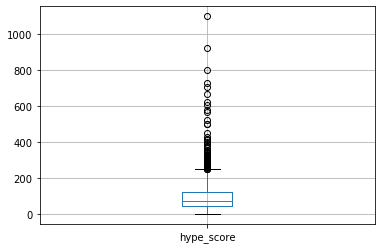

In [85]:
main_df.boxplot(column=[features[5]])

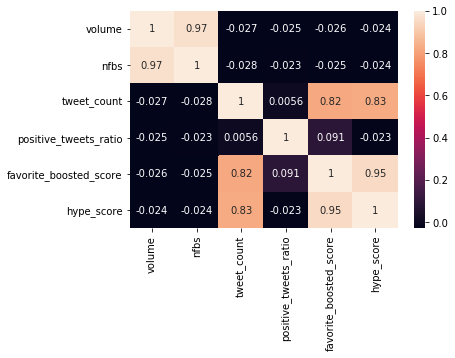

In [68]:
sns.heatmap(main_df[features].corr(), annot=True)

In [71]:
from eli5 import show_weights, show_prediction
show_weights(model)

Weight,Feature
0.2766,nfbs
0.1692,hype_score
0.1675,favorite_boosted_score
0.1551,volume
0.1253,positive_tweets_ratio
0.1063,tweet_count


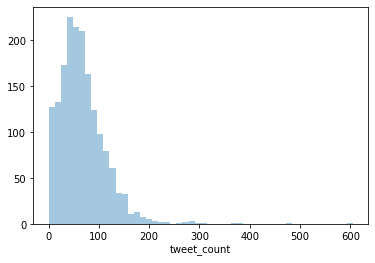

In [97]:
sns.distplot(main_df['tweet_count'], kde=False)

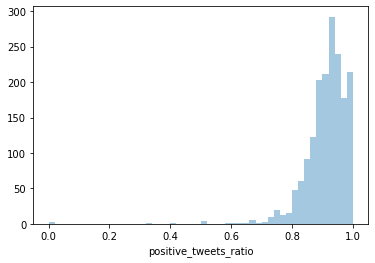

In [98]:
sns.distplot(main_df['positive_tweets_ratio'], kde=False)

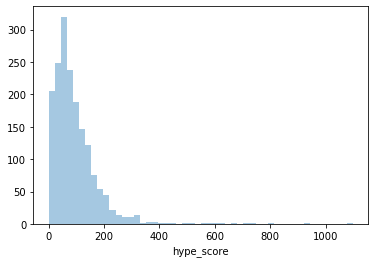

In [96]:
sns.distplot(main_df['hype_score'], kde=False)

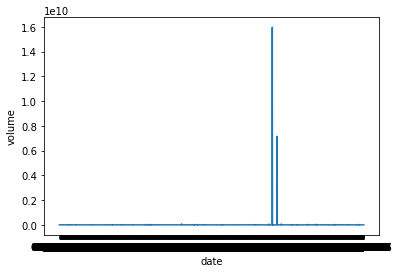

In [95]:
sns.lineplot(main_df['date'], main_df['volume'])